In [ ]:
import z3
import matplotlib as plt
plt.rcParams["figure.autolayout"] = True # to for tight_layout()
import pymc as pm
import pytensor as pt
import numpy as np

from sat_metropolis import models

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
# data
y_original = np.array([1087, 1008, 1068, 1204, 1158, 1151, 1143])

In [3]:
# experiment setup
num_con = 3
reduction_factor = 2
max_int_bv = 2**10-1
 
## Get models
(s, num_vars) = models.get_roads_smt(max_int = max_int_bv, 
                                     num_con=num_con,
                                     y_reduction_factor=reduction_factor)

[(1, 2), (1, 3), (1, 4), (2, 3), (2, 4), (3, 4)]


In [4]:
# get one sample for initial state for the experiment providing an initial state
s.check()
m = s.model()
init_state = [v.as_long() for (k,v) in sorted([(int(str(v).replace('x','')), m[v]) for v in m], key=lambda x: x[0])]
print(init_state)

[39, 0, 504, 0, 0, 30]


In [5]:
# set data according to number of connections and reduction factor in setup
A = models.__gen_conf_matrix(np.array([1,2,3,4,5,6,7][:num_con]))
y = np.array([int(i/reduction_factor) for i in y_original[:num_con]])

[(1, 2), (1, 3), (1, 4), (2, 3), (2, 4), (3, 4)]


In [6]:
with pm.Model() as model_dirac:
    num_vars = A.shape[1]
    x = pm.DiscreteUniform('x',0,max_int_bv,shape=num_vars)
    for i in range(len(y)):
        vars_ = [x[j] for j in range(num_vars) if A[i][j] == 1]
        pm.DiracDelta(f'obs{i}', sum(vars_), observed=y[i])

**Regular Metropolis crashes because it cannot find a satisfying initial state**

In [7]:
with model_dirac:
    trace = pm.sample(
        draws=50_000,
        tune=1000,        
        step=pm.Metropolis(),
        chains=2
    ) 

SamplingError: Initial evaluation of model at starting point failed!
Starting values:
{'x': array([511, 511, 511, 511, 511, 511])}

Logp initial evaluation results:
{'x': -41.59, 'obs0': -inf, 'obs1': -inf, 'obs2': -inf}
You can call `model.debug()` for more details.

**If we manually provide a satisfying initial state, it cannot find any other satisfying state.**

In [8]:
# sampling
with model_dirac:
    trace = pm.sample(
        draws=10_000,
        tune=1000,
        chains=2,
        step=pm.Metropolis(),
        initvals={'x': init_state} # set initial state found with Z3
    ) 

Multiprocess sampling (2 chains in 2 jobs)
Metropolis: [x]


Output()

Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 4 seconds.
/home/pardo/programs/miniconda3/envs/mcmc_sat/lib/python3.12/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
We recommend running at least 4 chains for robust computation of convergence diagnostics


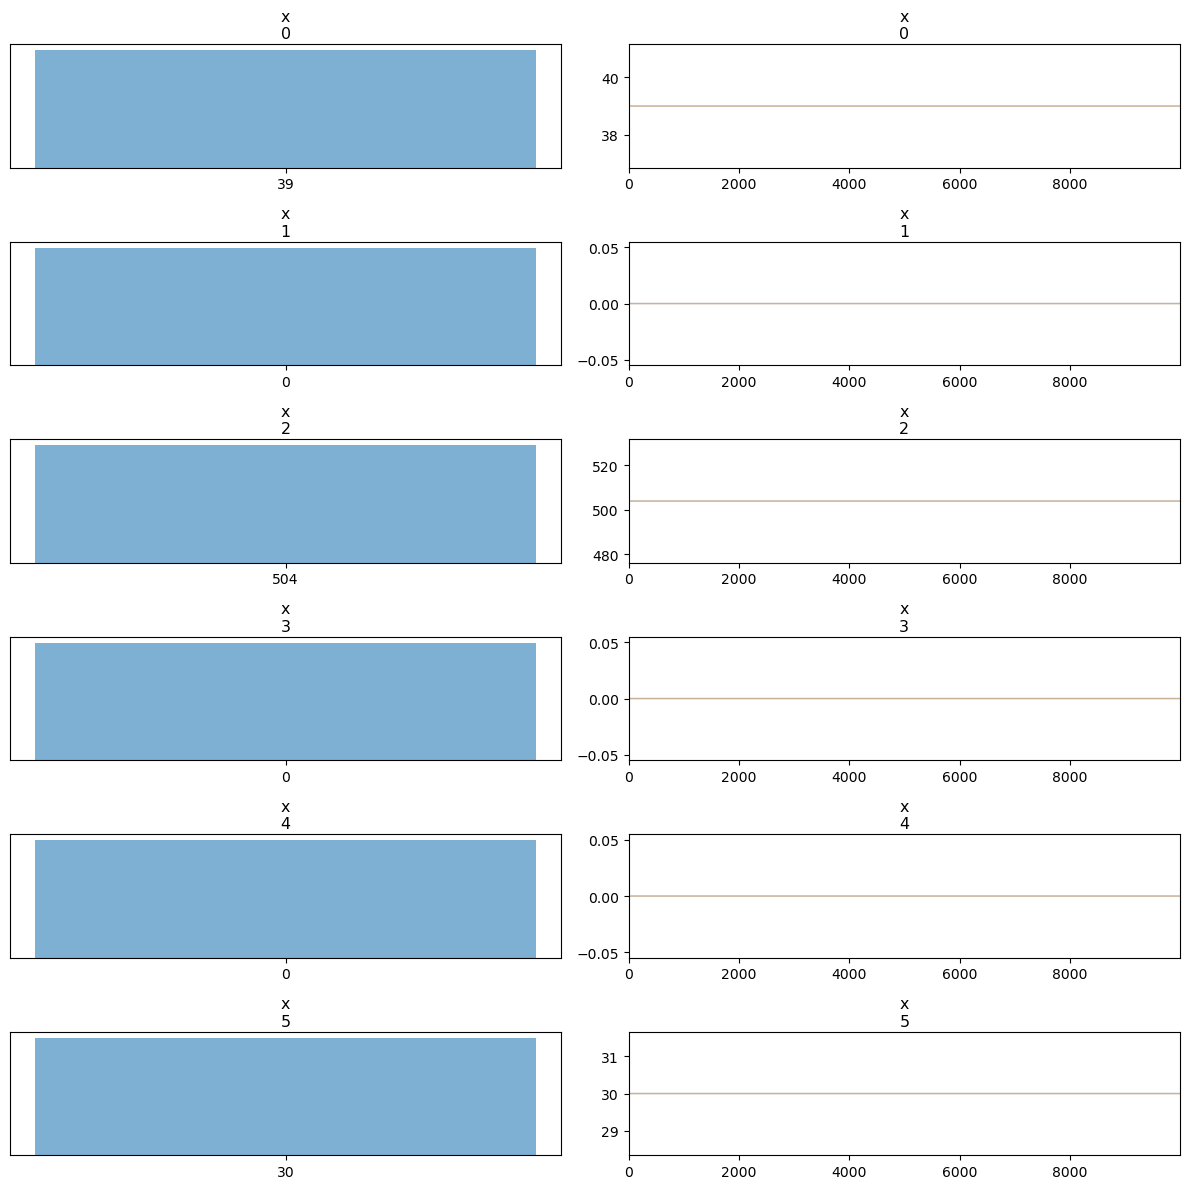

In [9]:
pm.plot_trace(trace, compact=False);

In [10]:
## Metropolis did not move from the initial state we provided
np.unique(trace.posterior['x'] == init_state)

array([ True])